# Pelatihan Detektor Anomali (Out-of-Distribution)

Notebook ini untuk membuat model "penjaga gerbang" yang dapat mendeteksi apakah sebuah gambar yang diunggah adalah gambar cuaca atau bukan (misalnya, gambar anime, diagram, atau objek lain).

In [9]:
import os
import sys
import cv2
import joblib
import numpy as np
from tqdm import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from src.configs.config import (
    DATA_RAW_PATH, ANOMALY_DATA_PATH, SAVED_MODEL_PATH, CLASSES, IMAGE_SIZE,
    HOG_ORIENTATIONS, HOG_PIXELS_PER_CELL, HOG_CELLS_PER_BLOCK
)

# Fungsi Helper

In [10]:
def resize_image(image):
    return cv2.resize(image, IMAGE_SIZE, interpolation=cv2.INTER_AREA)

def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def normalize_image(image):
    return image.astype('float32') / 255.0

def preprocess_image_for_feature_extraction(image):
    resized_color_uint8 = resize_image(image)
    gray_image = to_grayscale(resized_color_uint8)
    normalized_gray = normalize_image(gray_image)
    normalized_color = normalize_image(resized_color_uint8)
    return normalized_gray, normalized_color

def extract_hog_features(gray_image):
    return hog(gray_image, orientations=HOG_ORIENTATIONS, pixels_per_cell=HOG_PIXELS_PER_CELL,
               cells_per_block=HOG_CELLS_PER_BLOCK, block_norm='L2-Hys', visualize=False, transform_sqrt=True)

def extract_color_histogram(color_image):
    hsv_image = cv2.cvtColor((color_image * 255).astype(np.uint8), cv2.COLOR_BGR2HSV)
    hist_h = cv2.calcHist([hsv_image], [0], None, [180], [0, 180])
    hist_s = cv2.calcHist([hsv_image], [1], None, [32], [0, 256])
    hist_v = cv2.calcHist([hsv_image], [2], None, [32], [0, 256])
    cv2.normalize(hist_h, hist_h)
    cv2.normalize(hist_s, hist_s)
    cv2.normalize(hist_v, hist_v)
    return np.concatenate((hist_h, hist_s, hist_v)).flatten()

def extract_lbp_features(gray_image):
    gray_image_uint8 = (gray_image * 255).astype(np.uint8)
    radius, n_points = 8, 24
    lbp = local_binary_pattern(gray_image_uint8, n_points, radius, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_color_moments(color_image):
    lab_image = cv2.cvtColor((color_image * 255).astype(np.uint8), cv2.COLOR_BGR2Lab)
    l, a, b = cv2.split(lab_image)
    channels = [l, a, b]
    features = []
    for channel in channels:
        mean = np.mean(channel)
        std = np.std(channel)
        if std > 1e-6:
            skewness = skew(channel.flatten())
        else:
            skewness = 0.0
        features.extend([mean, std, skewness])
    return np.array(features)

def extract_glcm_features(gray_image):
    gray_image_uint8 = (gray_image * 255).astype(np.uint8)
    distances = [1, 3, 5]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(gray_image_uint8, distances=distances, angles=angles, symmetric=True, normed=True)
    features = []
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    for prop in props:
        features.append(graycoprops(glcm, prop).ravel())
    return np.concatenate(features)

def extract_gabor_features(gray_image):
    img = (gray_image * 255).astype(np.uint8)
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 4):
        for lambd in np.arange(np.pi / 4, np.pi, np.pi / 4):
            for sigma in (1, 3):
                kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, 0.5, 0, ktype=cv2.CV_32F)
                filters.append(kernel)
    features = []
    for kernel in filters:
        filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        features.append(filtered_img.mean())
        features.append(filtered_img.std())
    return np.array(features)

def extract_sobel_features(gray_image):
    img_uint8 = (gray_image * 255).astype(np.uint8)
    sobelx = cv2.Sobel(img_uint8, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img_uint8, cv2.CV_64F, 0, 1, ksize=3)
    magnitude = np.sqrt(sobelx**2 + sobely**2)
    (hist, _) = np.histogram(magnitude.ravel(), bins=32, range=(0, 256))
    hist = hist.astype("float")
    hist /= (hist.sum() + 1e-6)
    return hist

def extract_features(gray_image, color_image):
    hog_features = extract_hog_features(gray_image)
    color_hist_features = extract_color_histogram(color_image)
    lbp_features = extract_lbp_features(gray_image)
    gabor_features = extract_gabor_features(gray_image)
    sobel_features = extract_sobel_features(gray_image)
    glcm_features = extract_glcm_features(gray_image)
    color_moments = extract_color_moments(color_image)
    all_features = np.hstack([hog_features, color_hist_features, lbp_features, gabor_features, sobel_features, glcm_features, color_moments])
    if np.isnan(all_features).any():
        all_features = np.nan_to_num(all_features)
    return all_features

def load_and_extract_features(folder_path, desc="Extracting"):
    all_features = []
    image_paths = []
    # Mendukung sub-folder atau flat-folder
    for root, _, files in os.walk(folder_path):
        for filename in files:
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(root, filename))

    for img_path in tqdm(image_paths, desc=desc):
        try:
            image = cv2.imread(img_path)
            if image is None: continue
            gray_img, color_img = preprocess_image_for_feature_extraction(image)
            features = extract_features(gray_img, color_img)
            all_features.append(features)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            
    return np.array(all_features)

## Memuat Data dan Ekstraksi Fitur

In [11]:
print(f"Memuat data normal dari: {DATA_RAW_PATH}")
normal_features = load_and_extract_features(DATA_RAW_PATH, desc="Normal Images")

print(f"\nMemuat data anomali dari: {ANOMALY_DATA_PATH}")
anomaly_features = load_and_extract_features(ANOMALY_DATA_PATH, desc="Anomaly Images")

print(f"\nEkstraksi selesai.")
print(f"Jumlah sampel normal: {len(normal_features)}")
print(f"Jumlah sampel anomali: {len(anomaly_features)}")
print(f"Dimensi fitur: {normal_features.shape[1]}")

Memuat data normal dari: d:\program\python-project\svm-models\build\data\raw


Normal Images: 100%|██████████| 1200/1200 [02:12<00:00,  9.02it/s]



Memuat data anomali dari: d:\program\python-project\svm-models\build\data\anomaly


Anomaly Images: 100%|██████████| 1200/1200 [01:40<00:00, 11.99it/s]


Ekstraksi selesai.
Jumlah sampel normal: 1200
Jumlah sampel anomali: 886
Dimensi fitur: 8531


### Melatih Model Klasifikasi Biner (SVC)

Ukuran data latih: 1668
Ukuran data uji: 418

Memulai pencarian hyperparameter acak untuk SVC biner...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .........................svc__C=1, svc__gamma=scale; total time=   6.1s
[CV] END .........................svc__C=1, svc__gamma=scale; total time=   6.2s
[CV] END .........................svc__C=1, svc__gamma=scale; total time=   6.4s
[CV] END ..........................svc__C=1, svc__gamma=auto; total time=   6.1s
[CV] END ..........................svc__C=1, svc__gamma=auto; total time=   6.3s
[CV] END ..........................svc__C=1, svc__gamma=auto; total time=   6.4s
[CV] END .........................svc__C=10, svc__gamma=auto; total time=   6.1s
[CV] END .........................svc__C=10, svc__gamma=auto; total time=   6.2s
[CV] END .........................svc__C=10, svc__gamma=auto; total time=   6.5s
[CV] END .......................svc__C=100, svc__gamma=0.001; total time=   7.2s
[CV] END .................

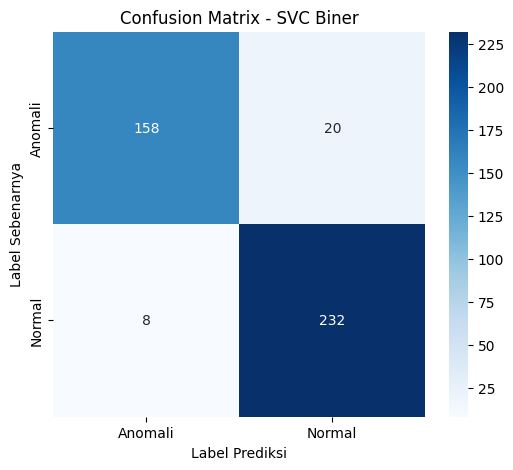


Model disimpan di: d:\program\python-project\svm-models\build\saved_models\anomaly_detector.pkl


In [ ]:
# Gabungkan fitur
X = np.vstack((normal_features, anomaly_features))

# Buat label: 1 untuk normal, -1 untuk anomali
y = np.array([1] * len(normal_features) + [-1] * len(anomaly_features))

# Bagi data untuk pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Ukuran data latih: {len(X_train)}")
print(f"Ukuran data uji: {len(X_test)}")

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(kernel='rbf', random_state=42))
])

param_dist = {
    'svc__C': [1, 10, 50, 100],
    'svc__gamma': ['scale', 'auto', 0.001, 0.01]
}

random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=10, cv=3, verbose=2, random_state=42, n_jobs=1, refit=True)
print("\nMemulai pencarian hyperparameter acak untuk SVC biner...")
random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print(f"\nParameter terbaik ditemukan: {random_search.best_params_}")

# Evaluasi pada set uji
y_pred = best_model.predict(X_test)
print("\nLaporan Klasifikasi untuk SVC Biner:")
print(classification_report(y_test, y_pred, target_names=['Anomali (-1)', 'Normal (1)']))

# Tampilkan Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Anomali', 'Normal'], yticklabels=['Anomali', 'Normal'])
plt.title('Confusion Matrix - SVC Biner')
plt.ylabel('Label Sebenarnya')
plt.xlabel('Label Prediksi')
plt.show()

output_dir = os.path.dirname(SAVED_MODEL_PATH)
anomaly_model_path = os.path.join(output_dir, 'anomaly_detector.pkl')
os.makedirs(output_dir, exist_ok=True)
joblib.dump(best_model, anomaly_model_path)
print(f"\nModel disimpan di: {anomaly_model_path}")